In [47]:
import random
import numpy as np

N = 4
SIZE = 3*N*(N-1)+1
GOAL = np.concatenate((range(1, SIZE//2+1),[0], range(SIZE//2+1, SIZE)))

ORDER = []
l, r = 0, N-1
for j in range(-N+1, N):
    for i in range(l, r+1):
        ORDER.append((i, j))
    if j < 0: l -= 1
    else: r -= 1
assert len(ORDER) == SIZE

LOOKUP = {}
for i, p in enumerate(ORDER):
    LOOKUP[p] = i

class Balto:
    moves = [*range(12)]
    moves_inverse = [8, 9, 10, 11, 6, 7, 4, 5, 0, 1, 2, 3]

    def __init__(self): #, cw, a, steps=0):
        self.reset()

    def reset(self):
        self.state = GOAL.copy()
        self.zero = SIZE//2

    def done(self):
        return np.all(GOAL == self.state)

    def step(self, action):
        group = [ORDER[self.zero]]
        if action % 6 == 0:
            group.append((group[0][0]+1, group[0][1]-1))
            group.append((group[0][0]+1, group[0][1]))
        elif action % 6 == 1:
            group.append((group[0][0]+1, group[0][1]))
            group.append((group[0][0], group[0][1]+1))
        elif action % 6 == 2:
            group.append((group[0][0], group[0][1]+1))
            group.append((group[0][0]-1, group[0][1]+1))
        elif action % 6 == 3:
            group.append((group[0][0]-1, group[0][1]+1))
            group.append((group[0][0]-1, group[0][1]))
        elif action % 6 == 4:
            group.append((group[0][0]-1, group[0][1]))
            group.append((group[0][0], group[0][1]-1))
        elif action % 6 == 5:
            group.append((group[0][0], group[0][1]-1))
            group.append((group[0][0]+1, group[0][1]-1))

        for i, p in enumerate(group):
            if p[0] < 0 and p[1] == N:
                group[i] = (p[0]+N, -N+1)
            elif p[0] > 0 and p[1] == -N:
                group[i] = (p[0]-N, N-1)
            elif sum(p) == N and p[1] > 0:
                group[i] = (p[0]-N+1, p[1]-N)
            elif sum(p) == -N and p[1] < 0:
                group[i] = (p[0]+N-1, p[1]+N)
            elif p[0] == N and p[1] > -N:
                group[i] = (-N+1, p[1]+N-1)
            elif p[0] == -N and p[1] < N:
                group[i] = (N-1, p[1]-N+1)

        if action < 6:
            self.state[LOOKUP[group[0]]] = self.state[LOOKUP[group[2]]]
            self.state[LOOKUP[group[2]]] = self.state[LOOKUP[group[1]]]
            self.state[LOOKUP[group[1]]] = 0
            self.zero = LOOKUP[group[1]]
        else:
            self.state[LOOKUP[group[0]]] = self.state[LOOKUP[group[1]]]
            self.state[LOOKUP[group[1]]] = self.state[LOOKUP[group[2]]]
            self.state[LOOKUP[group[2]]] = 0
            self.zero = LOOKUP[group[2]]

    def scrambler(self, scramble_length):
        while True:
            self.reset()
            cw = random.randint(0,1) == 0
            last = -1
            for _ in range(scramble_length):
                if cw: move = random.randint(0,5)
                else: move = random.randint(6,11)

                while last != -1 and move == self.moves_inverse[last]:
                    if cw: move = random.randint(0,5)
                    else: move = random.randint(6,11)

                self.step(move)

                yield self.state, move
                last = move
                cw = not cw

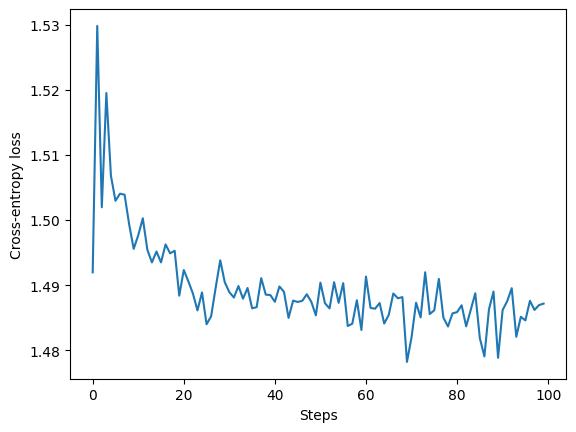

100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Trained on data equivalent to 100000 solves.
[1.491963505744934, 1.529826283454895, 1.5019687414169312, 1.5195153951644897, 1.5068222284317017, 1.5029648542404175, 1.504056692123413, 1.5038965940475464, 1.4993516206741333, 1.4955819845199585, 1.4976686239242554, 1.5002774000167847, 1.4954432249069214, 1.4934942722320557, 1.4951741695404053, 1.4934993982315063, 1.4962595701217651, 1.4948861598968506, 1.4952908754348755, 1.488388180732727, 1.4923242330551147, 1.4905873537063599, 1.4887250661849976, 1.486122488975525, 1.4888893365859985, 1.4839951992034912, 1.4852147102355957, 1.4896025657653809, 1.4938247203826904, 1.490440845489502, 1.488930106163025, 1.4881006479263306, 1.4898655414581299, 1.4879206418991089, 1.489567518234253, 1.4864448308944702, 1.4866265058517456, 1.491081714630127, 1.488545298576355, 1.4884833097457886, 1.4874444007873535, 1.4898030757904053, 1.488973617553711, 1.4849754571914673, 1.4876279830932617, 1.4874210357666016, 1.4875904321670532, 1.488602638244629, 1.4874

In [67]:
class TrainConfig:
    max_depth = 76                          # God's Number
    batch_size_per_depth = 1000
    num_steps = 100
    learning_rate = 1e-4
    ENABLE_FP16 = True                     # Set this to True if you want to train the model faster

import os
import numpy as np
from contextlib import nullcontext
from tqdm import trange

from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'device: {device}')
print(f'os.cpu_count(): {os.cpu_count()}')

env = Balto()

class LinearBlock(nn.Module):
    """
    Linear layer with ReLU and BatchNorm
    """
    def __init__(self, input_prev, embed_dim):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, embed_dim)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(embed_dim)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

class ResidualBlock(nn.Module):
    """
    Residual block with two linear layers
    """
    def __init__(self, embed_dim):
        super(ResidualBlock, self).__init__()
        self.layers = nn.ModuleList([
            LinearBlock(embed_dim, embed_dim),
            LinearBlock(embed_dim, embed_dim)
        ])

    def forward(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        x += inputs # skip-connection
        return x

class Model(nn.Module):
    """
    Fixed architecture following DeepCubeA.
    """
    def __init__(self, input_dim=SIZE**2, output_dim=len(env.moves)):
        super(Model, self).__init__()
        self.input_dim = input_dim
        self.embedding = LinearBlock(input_dim, 5000)
        self.layers = nn.ModuleList([
            LinearBlock(5000,1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000),
            ResidualBlock(1000)
        ])
        self.output = nn.Linear(1000, output_dim)

    def forward(self, inputs):
        # int indices => float one-hot vectors
        x = nn.functional.one_hot(inputs, num_classes=SIZE).to(torch.float)
        x = x.reshape(-1, self.input_dim)
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.output(x)
        return logits



class ScrambleGenerator(torch.utils.data.Dataset):
    def __init__(
            self,
            num_workers=os.cpu_count(),
            max_depth=TrainConfig.max_depth,
            total_samples=TrainConfig.num_steps*TrainConfig.batch_size_per_depth
        ):
        self.num_workers = num_workers
        self.max_depth = max_depth
        self.envs = [Balto() for _ in range(num_workers)]
        self.generators = [env.scrambler(self.max_depth) for env in self.envs]

        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, i):
        'generate one scramble, consisting of `self.max_depth` data points'
        worker_idx = i % self.num_workers
        X = np.zeros((self.max_depth, SIZE), dtype=int)
        y = np.zeros((self.max_depth,), dtype=int)
        for j in range(self.max_depth):
            state, last_move = next(self.generators[worker_idx])
            X[j, :] = state
            y[j] = last_move
        return X, y

def plot_loss_curve(h):
    fig, ax = plt.subplots(1, 1)
    ax.plot(h)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Cross-entropy loss")
    plt.show()

def train(model, dataloader):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=TrainConfig.learning_rate)
    g = iter(dataloader)
    ctx = torch.autocast(str(device), dtype=torch.float16) if TrainConfig.ENABLE_FP16 else nullcontext()
    h = []

    for i in trange(1, TrainConfig.num_steps + 1, smoothing=0):
        batch_x, batch_y = next(g)
        batch_x, batch_y = batch_x.reshape(-1, SIZE).to(device), batch_y.reshape(-1).to(device)

        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        h.append(loss.item())
        if i % 25 == 0:
            clear_output()
            plot_loss_curve(h)
    print(f"Trained on data equivalent to {TrainConfig.batch_size_per_depth * TrainConfig.num_steps} solves.")
    print(h)
    return model

if __name__ == '__main__':
    model = Model().to(device)
    model.load_state_dict(torch.load('model.pth', weights_only=True))
    dataloader = torch.utils.data.DataLoader(
        ScrambleGenerator(),
        num_workers=os.cpu_count(),
        batch_size=TrainConfig.batch_size_per_depth
    )

    # import cProfile
    # import re
    # cProfile.run('model = train(model, dataloader)', 'out')
    model = train(model, dataloader)

    torch.save(model.state_dict(), "model.pth")

In [20]:
import pstats
from pstats import SortKey
p = pstats.Stats('out')
p.sort_stats(SortKey.TIME).print_stats(10)

Fri Jan  3 12:37:37 2025    out

         4764701 function calls (4533163 primitive calls) in 94.774 seconds

   Ordered by: internal time
   List reduced from 1921 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      104   58.880    0.566   58.880    0.566 {method 'poll' of 'select.poll' objects}
     8501   17.617    0.002   17.617    0.002 {method 'item' of 'torch._C.TensorBase' objects}
     1400    0.790    0.001    0.790    0.001 {built-in method posix.read}
      100    0.761    0.008    0.761    0.008 {method 'run_backward' of 'torch._C._EngineBase' objects}
       10    0.577    0.058    0.577    0.058 {method 'encode' of 'ImagingEncoder' objects}
     7984    0.576    0.000   21.351    0.003 /usr/local/lib/python3.10/dist-packages/matplotlib/artist.py:1176(_update_props)
108057/1791    0.575    0.000    1.245    0.001 /usr/lib/python3.10/copy.py:128(deepcopy)
      528    0.398    0.001    0.398    0.001 /usr/local/lib/p

In [68]:
class SearchConfig:
    beam_width = 2**11                      # This controls the trade-off between time and optimality
    max_depth = 150
    ENABLE_FP16 = True                     # Set this to True if you want to solve faster

import torch
from contextlib import nullcontext
import time
from copy import deepcopy
import numpy as np

@torch.no_grad()
def beam_search(
        env,
        model,
        beam_width=SearchConfig.beam_width,
        max_depth=SearchConfig.max_depth,
        skip_redundant_moves=True,
    ):

    model.eval()
    with torch.autocast(str(device), dtype=torch.float16) if SearchConfig.ENABLE_FP16 else nullcontext():
        # metrics
        num_nodes_generated, time_0 = 0, time.time()
        candidates = [
            {"state":deepcopy(env.state), "path":[], "value":1.}
        ] # list of dictionaries

        for depth in range(max_depth+1):
            # TWO things at a time for every candidate: 1. check if solved & 2. add to batch_x
            batch_x = np.zeros((len(candidates), env.state.shape[-1]), dtype=np.int64)
            for i,c in enumerate(candidates):
                c_path, env.state = c["path"], c["state"]
                if c_path:
                    env.step(c_path[-1])
                    num_nodes_generated += 1
                    if env.done():
                        # Revert: array of indices => array of notations
                        c_path = [str(env.moves[i]) for i in c_path]
                        return True, {'solutions':c_path, "num_nodes_generated":num_nodes_generated, "times":time.time()-time_0}
                batch_x[i, :] = env.state

            # after checking the nodes expanded at the deepest
            if depth==max_depth:
                print("Solution not found.")
                return False, None

            # make predictions with the trained DNN
            batch_x = torch.from_numpy(batch_x).to(device)
            batch_p = model(batch_x)
            batch_p = torch.nn.functional.softmax(batch_p, dim=-1)
            batch_p = batch_p.detach().cpu().numpy()

            # loop over candidates
            candidates_next_depth = []  # storage for the depth-level candidates storing (path, value, index).
            for i, c in enumerate(candidates):
                c_path = c["path"]
                value_distribution = batch_p[i, :] # output logits for the given state
                value_distribution *= c["value"] # multiply the cumulative probability so far of the expanded path

                for m, value in zip(env.moves_inverse, value_distribution): # iterate over all possible moves.
                    # predicted value to expand the path with the given move.

                    if c_path:
                        if (c_path[-1] < 6) == (m < 6): continue

                    if c_path and skip_redundant_moves:
                        # Two cancelling moves
                        if env.moves_inverse[c_path[-1]] == m:
                            continue

                    # add to the next-depth candidates unless 'continue'd.
                    candidates_next_depth.append({
                        'state':deepcopy(c['state']),
                        "path": c_path+[m],
                        "value":value,
                    })

            # sort potential paths by expected values and renew as 'candidates'
            candidates = sorted(candidates_next_depth, key=lambda item: -item['value'])
            # if the number of candidates exceed that of beam width 'beam_width'
            candidates = candidates[:beam_width]

env = Balto()
# env.state = np.asarray([15,13,8,
#         14,17,9,16,
#         10,18,0,4,12,
#         3,7,2,5,
#         11,6,1])
env.state = np.asarray([
15,35,24,23,
20,36,33,31,29,
27,26,30,25,18,2,
19,14,7,32,28,34,5,
4,13,0,8,1,11,
9,21,3,17,10,
12,22,6,16,
])

model = Model()
model.load_state_dict(torch.load('model.pth', weights_only=True))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
success, result = beam_search(env, model)
if success:
    print(result)
    s = list(map(int, result['solutions']))
    print(len(s))
    for n in s:
        if n < 6: print(n+1, end='')
        else: print(f'{4+n:x}', end='')
    print()

Solution not found.
